In [9]:
# Import all relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import shap

from torchsummary import summary
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np 
import time

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
np.random.seed(seed)

In [10]:
# Define the directory path
data_dir = './processed_dataset'

# Create the ImageFolder dataset
dataset = datasets.DatasetFolder(data_dir, loader=torch.load, extensions=".pt")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
# Set DataLoader
batchSize = 16  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train_dataset, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False) # no need to shuffle test data

count_batch_train, count_batch_test = 0, 0

In [12]:
for xb, yb in train_loader:
  print(count_batch_train, end='', flush=True)
  count_batch_train += 1
  print("\r", end='', flush=True)
print(f'There are {count_batch_train} batches in train_loader')

for xb, yb in test_loader:
  print(count_batch_test, end='', flush=True)
  count_batch_test += 1
  print("\r", end='', flush=True)
print(f'There are {count_batch_test} batches in test_loader')

for i, j in train_loader:
    size = i.shape
    break

print(size)

There are 413 batches in train_loader
There are 104 batches in test_loader
torch.Size([16, 1, 224, 224])


In [13]:
def printSummary(model, name="network", size=(1, 784), visualize=False):
    print("NETWORK NAME: ", name)
    summary(model, size)
    print(2*"\n")
    if visualize:
        # Generate a visualization of the network
        x = torch.randn(1, size[1])
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render(name, format="png")

In [14]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_classes, kernel_sizes=None):
        super(ConvNet, self).__init__()

        if kernel_sizes is None:
            k = [[3]]
        else:
            k = kernel_sizes

        self.conv1 = nn.Conv2d(input_channels, hidden_channels[0], kernel_size=k[0][0], stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()  # Add module list for pooling layers

        for i in range(1, len(hidden_channels)):
            self.conv_layers.append(nn.Conv2d(hidden_channels[i-1], hidden_channels[i], kernel_size=k[i][0], stride=1, padding=1))
            self.relu = nn.ReLU()
            self.pool_layers.append(nn.MaxPool2d(kernel_size=k[i][1], stride=2))  # Add max pooling layer

        self.fc = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)

        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):  # Iterate over conv and pool layers
            out = conv_layer(out)
            out = self.relu(out)
            out = pool_layer(out)  # Apply max pooling

        out = F.avg_pool2d(out, kernel_size=out.size()[2:])  # Global average pooling
        out = out.view(out.size(0), -1)  # Flatten the tensor

        out = self.fc(out)

        if not self.training:
            out = F.softmax(out, dim=1)
        
        return out

In [44]:
def trainModel(model, data_loader, epochSize=20):
    train_loader, test_loader = data_loader[0], data_loader[1]

    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters())

    loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []
    total_acc_per_epoch = []
    time_per_epoch = []
    exec_time = []

    start_total_time = time.time()
    for epoch in range(epochSize):

        loss = 0
        start_epoch_time = time.time()

        count = 1
        for input_batch, target_batch in train_loader:
            print(
                f"Epoch: {epoch + 1} => {time.time() - start_epoch_time:.2f}s {(count/count_batch_train)*100:.3f}%", end='')

            # Zero the gradients
            opt.zero_grad()

            # Forward pass
            predict_batch = model(input_batch)

            # Compute loss
            loss_batch = loss_fn(predict_batch, target_batch)

            # Backward pass and update weights
            loss_batch.backward()
            opt.step()

            loss += loss_batch.item()  # store the loss
            count += 1
            print('\r', end='', flush=True)

        loss_per_epoch.append(loss)
        # print(loss)

        # CALCULATE TRAIN ACCURACY
        correct = 0
        total = 0
        train_accuracy = 0

        with torch.no_grad():
            count = 1
            for images, labels in train_loader:
                print(f"Epoch: {epoch + 1} => {time.time() - start_epoch_time:.2f}s || Calculating Training Accuracy... {(count/count_batch_train)*100:.3f}%", end='', flush=True)
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1
                print('\r', end='', flush=True)

        # Calculate accuracy
        train_accuracy = correct / total
        train_acc_per_epoch.append(train_accuracy)

        # CALCULATE TEST ACCURACY
        correct = 0
        total = 0
        test_accuracy = 0

        with torch.no_grad():
            count = 1
            for images, labels in test_loader:
                print(f"Epoch: {epoch + 1} => {time.time() - start_epoch_time:.2f}s || Calculating Testing Accuracy... {(count/count_batch_test)*100:.3f}%", end='', flush=True)
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1
                print('\r', end='', flush=True)

        # Calculate accuracy
        test_accuracy = correct / total
        test_acc_per_epoch.append(test_accuracy)

        time_epoch = time.time() - start_epoch_time
        time_current = time.time() - start_total_time

        time_per_epoch.append(time_epoch)
        exec_time.append(time_current)

        total_accuracy = 0.3*train_accuracy + 0.7*test_accuracy
        total_acc_per_epoch.append(total_accuracy)

        print(f'Epoch: {epoch+1} || Loss: {loss} || Train Acc: {train_accuracy * 100:.4f}% || Test Acc: {test_accuracy * 100:.4f}% || Total Acc: {total_accuracy * 100:.4f}% || Epoch Time: {time_epoch:.4f} s || Current Runtime: {time_current:.4f} s')

    output = {
        'loss': loss_per_epoch,
        'train_acc': train_acc_per_epoch,
        'test_acc': test_acc_per_epoch,
        'total_acc': total_acc_per_epoch,
        'epoch_time': time_per_epoch,
        'exec_time': exec_time
    }

    return output

In [53]:
model_CNN2 = ConvNet(1, [4], num_classes=5, kernel_sizes=[[2], [3, 2]])
# printSummary(model_CNN2, size=(1, 50176), name="model_ConvNet_v1")
model_CNN2_result = trainModel(model_CNN2, [train_loader, test_loader], epochSize=30)

Epoch: 1 || Loss: 665.0960241556168 || Train Acc: 20.0758% || Test Acc: 19.6970% || Total Acc: 19.8106% || Epoch Time: 44.8131 s || Current Runtime: 44.8131 s
Epoch: 2 || Loss: 648.5965774059296 || Train Acc: 22.9394% || Test Acc: 23.1515% || Total Acc: 23.0879% || Epoch Time: 43.5493 s || Current Runtime: 88.3626 s
Epoch: 3 || Loss: 623.2174354791641 || Train Acc: 38.7273% || Test Acc: 39.8788% || Total Acc: 39.5333% || Epoch Time: 38.2301 s || Current Runtime: 126.5927 s
Epoch: 4 || Loss: 593.1013256311417 || Train Acc: 38.5758% || Test Acc: 38.6667% || Total Acc: 38.6394% || Epoch Time: 33.6381 s || Current Runtime: 160.2309 s
Epoch: 5 || Loss: 565.6405856609344 || Train Acc: 40.2273% || Test Acc: 40.9091% || Total Acc: 40.7045% || Epoch Time: 33.6255 s || Current Runtime: 193.8565 s
Epoch: 6 || Loss: 542.2273944616318 || Train Acc: 44.0303% || Test Acc: 43.6364% || Total Acc: 43.7545% || Epoch Time: 33.6446 s || Current Runtime: 227.5012 s
Epoch: 7 || Loss: 522.9887040257454 || Tra

In [54]:
import torchviz

# Generate the graph using torchviz
graph = torchviz.make_dot(model_CNN2(torch.rand(1, 1, 224, 224)), params=dict(model_CNN2.named_parameters()))

# Save the graph as a PDF file
graph.render("convnet_graph")

'convnet_graph.pdf'

Text(0, 0.5, 'CE Loss')

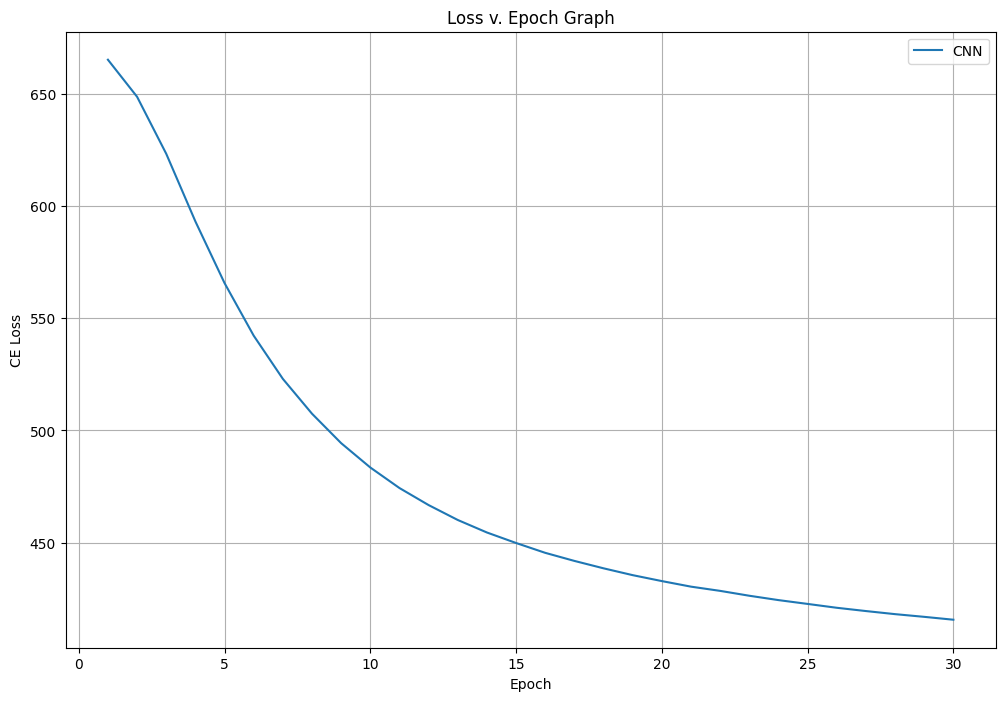

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Loss v. Epoch Graph
ax1.plot(range(1, 30+1), model_CNN2_result['loss'], label="CNN")
ax1.legend()
ax1.grid()
ax1.set_title("Loss v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CE Loss")

[]

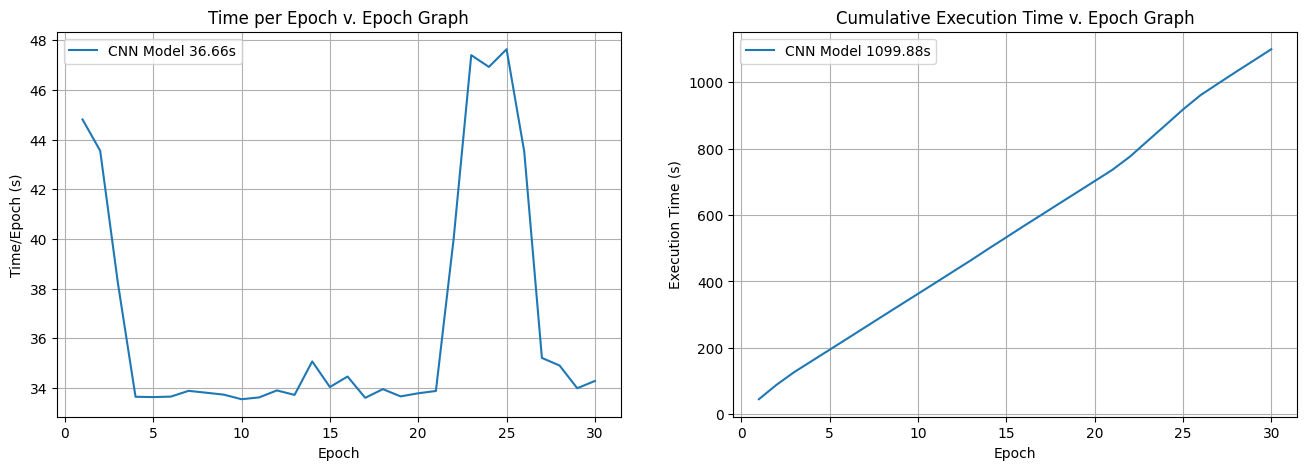

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

epochSize = 30
# Time per Epoch v. Epoch Graph
ax1.plot(range(1, epochSize+1), model_CNN2_result['epoch_time'], label=f"CNN Model {np.mean(model_CNN2_result['epoch_time']):.2f}s")
ax1.set_title("Time per Epoch v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time/Epoch (s)")
ax1.legend()
ax1.grid()

# Time per Epoch v. Epoch Graph
ax2.plot(range(1, epochSize+1), model_CNN2_result['exec_time'], label=f"CNN Model {model_CNN2_result['exec_time'][-1]:.2f}s")
ax2.set_title("Cumulative Execution Time v. Epoch Graph")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Execution Time (s)")
ax2.legend()
ax2.grid()
plt.plot()

In [59]:
def evaluate_model(model, data_loader, model_name=""): #or def compute_accuracy():  , use whatever conventions that you like

    model.eval()

    train_loader, test_loader = data_loader[0], data_loader[1]

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Train Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Test Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")
    return accuracy

evaluate_model(model_CNN2, [train_loader, test_loader], "CNN")

CNN => Train Accuracy: 58.62% || Correct Labels: 3869 / Wrong Labels: 2731
CNN => Test Accuracy: 58.42% || Correct Labels: 964 / Wrong Labels: 686


0.5842424242424242

Text(0.5, 1.0, 'CNN Accuracy v. Epoch')

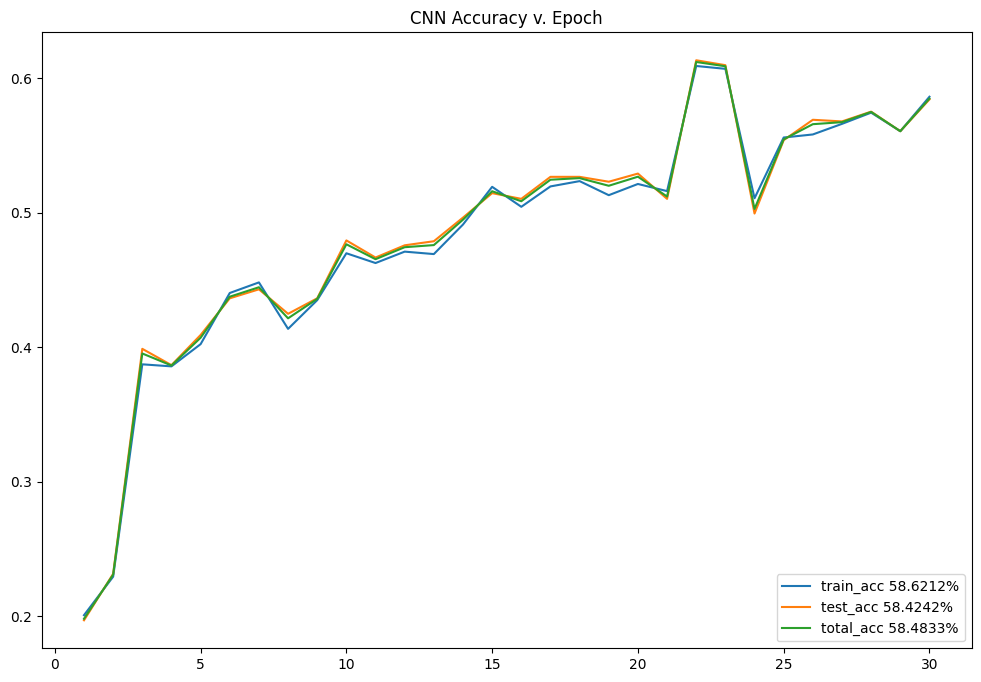

In [61]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Accuracy v. Epoch Graph
ax1.plot(range(1, epochSize+1), model_CNN2_result['train_acc'], label=f"train_acc {model_CNN2_result['train_acc'][-1]*100:.4f}%")
ax1.plot(range(1, epochSize+1), model_CNN2_result['test_acc'], label=f"test_acc {model_CNN2_result['test_acc'][-1]*100:.4f}%")
ax1.plot(range(1, epochSize+1), model_CNN2_result['total_acc'], label=f"total_acc {model_CNN2_result['total_acc'][-1]*100:.4f}%")
ax1.legend(loc='lower right')
ax1.set_title("CNN Accuracy v. Epoch")

In [62]:
# Save the model
scripted_model = torch.jit.script(model_CNN2)
torch.jit.save(scripted_model, './models/model_ConvNet_v3.pt')
print("Saved!")

Saved!


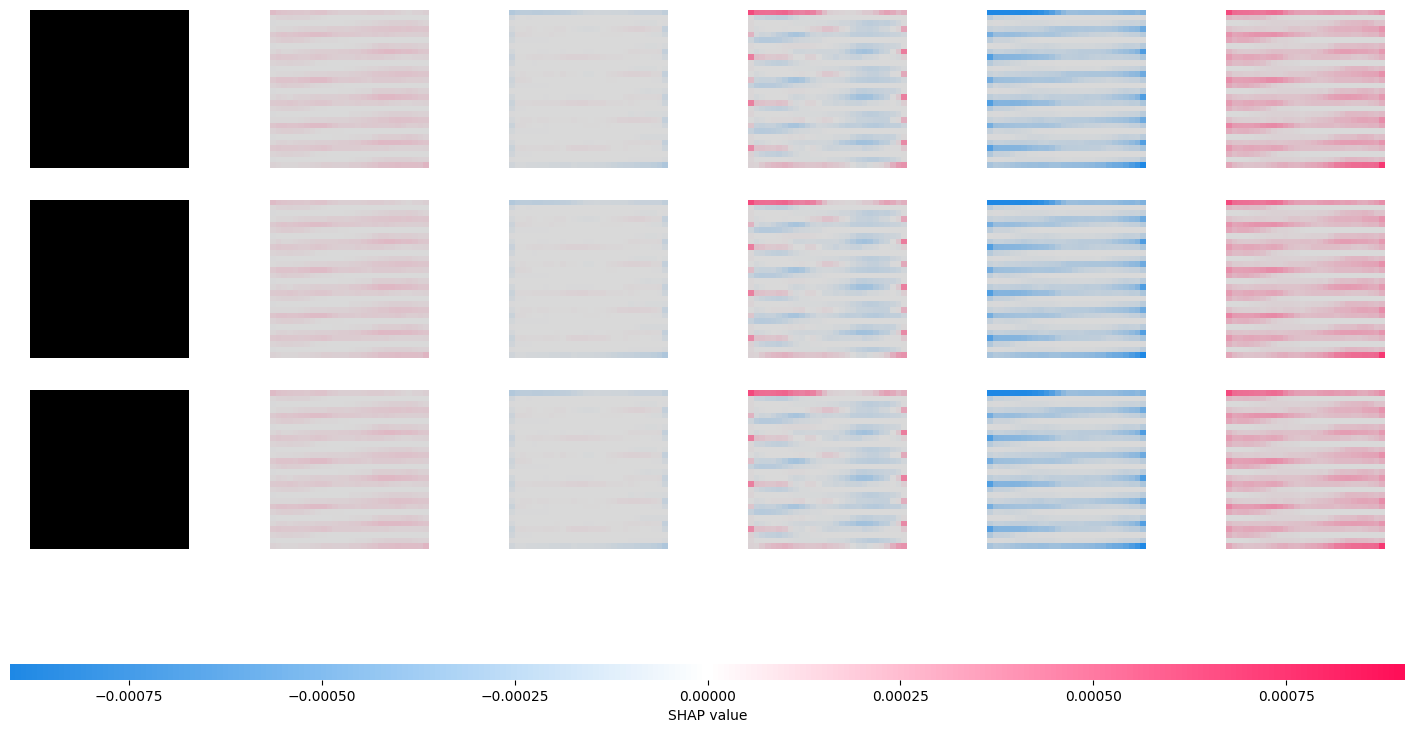

In [73]:
batch = next(iter(test_loader))
images, _ = batch
images = images.view(-1, 1, 28, 28)

background = images[:2]
test_images= images[2:5]

e = shap.DeepExplainer(model_CNN2, images)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
print(_[100:110])